# Анализ признаков и их значимости

## Импорт библиотек

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance

import shap

## Импорт данных

In [4]:
df = pd.read_csv('data/Air_Quality.csv')

# Добавим случайные признаки, для понимания, какие данные могут быть в датасете.
df["random_feature1"] = np.random.rand(len(df)) * 10
df["random_feature2"] = np.random.rand(len(df)) * 100
df["random_feature3"] = np.random.rand(len(df))

# Для анализа берем только числовые признаки
numeric_features = df.select_dtypes('number').columns

df = df[numeric_features]
df.head(3)

,CO,NO2,SO2,O3,PM2.5,PM10,AQI,random_feature1,random_feature2,random_feature3
0,325.0,21.1,2.5,35.0,15.4,15.6,20.483337,3.283773,99.407817,0.612598
1,369.0,20.8,2.7,35.0,15.1,15.3,20.425000,7.994879,83.926942,0.300481
2,419.0,20.4,3.0,34.0,15.6,15.8,20.333332,9.199383,29.916071,0.634621


## Анализ данных

### Построение графиков распределений признаков

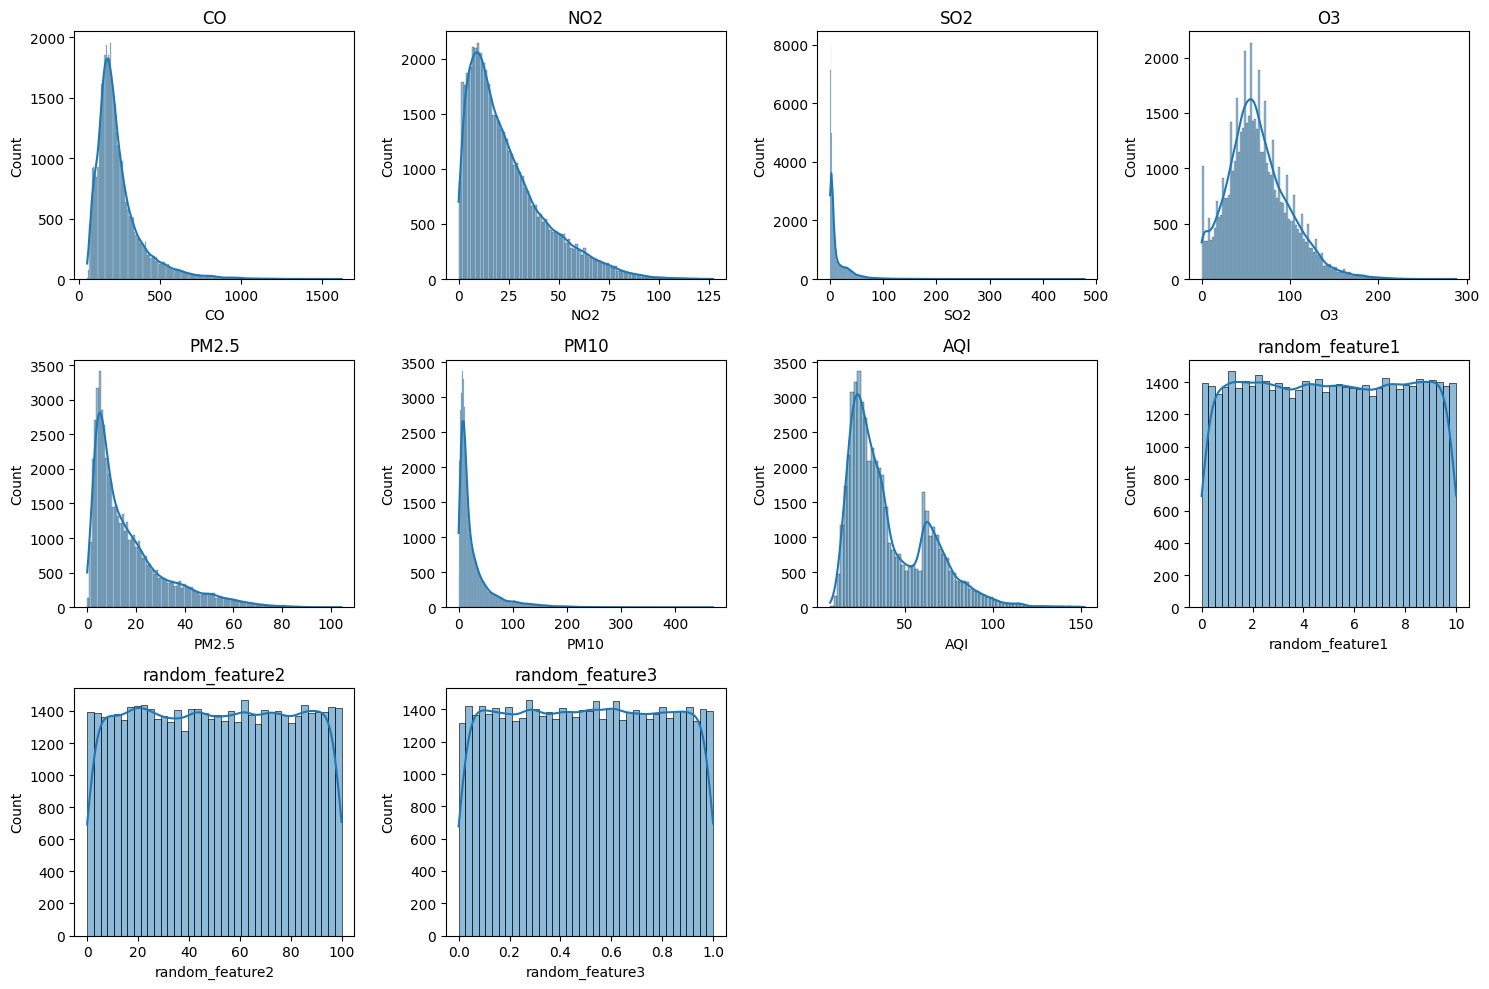

In [5]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

Видны странные признаки, которые имеют сплошной график распределения.

## Оценка важности признаков

После анализа признаков займемся оценкой важности и фильтрацией признаков.

Ниже будут разные подходы к оценке признаков. В работе лучше использовать несколько подходов, так результат будет объективнее.

### Корреляционный анализ

- Сильно коррелированные признаки могут приводить к мультиколлинеарности

- Такие признаки можно удалить или объединить

In [6]:
corr_matrix = df[numeric_features].corr()

corr_matrix

,CO,NO2,SO2,O3,PM2.5,PM10,AQI,random_feature1,random_feature2,random_feature3
CO,1.000000,0.617685,0.392683,0.002812,0.615434,0.432946,0.479892,-0.005943,-0.001227,0.009475
NO2,0.617685,1.000000,0.467116,-0.424233,0.659447,0.430253,0.398633,-0.004970,-0.002650,0.009252
SO2,0.392683,0.467116,1.000000,-0.028798,0.518649,0.373316,0.443628,-0.009375,0.005802,0.004218
O3,0.002812,-0.424233,-0.028798,1.000000,0.090535,0.183408,0.412755,-0.004395,0.003056,-0.001076
PM2.5,0.615434,0.659447,0.518649,0.090535,1.000000,0.874455,0.808558,-0.008617,-0.002926,0.009275
PM10,0.432946,0.430253,0.373316,0.183408,0.874455,1.000000,0.799229,-0.007202,-0.001916,0.008311
AQI,0.479892,0.398633,0.443628,0.412755,0.808558,0.799229,1.000000,-0.007852,-0.002812,0.007286
random_feature1,-0.005943,-0.004970,-0.009375,-0.004395,-0.008617,-0.007202,-0.007852,1.000000,0.003449,0.000852
random_feature2,-0.001227,-0.002650,0.005802,0.003056,-0.002926,-0.001916,-0.002812,0.003449,1.000000,0.001514
random_feature3,0.009475,0.009252,0.004218,-0.001076,0.009275,0.008311,0.007286,0.000852,0.001514,1.000000


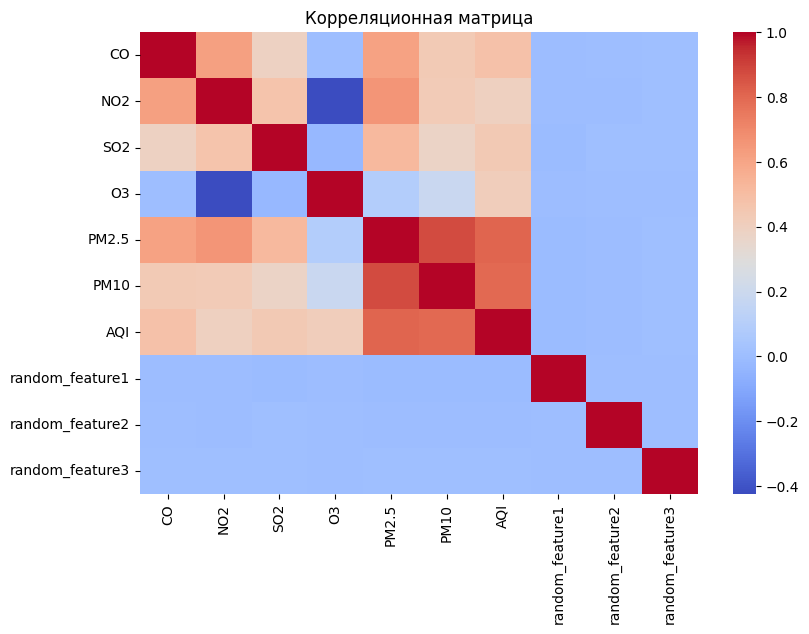

In [7]:
plt.figure(figsize=(9, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Корреляционная матрица")
plt.show()

In [8]:
corr_with_target = corr_matrix["AQI"].sort_values(ascending=False)
corr_with_target

AQI                1.000000
PM2.5              0.808558
PM10               0.799229
CO                 0.479892
SO2                0.443628
O3                 0.412755
NO2                0.398633
random_feature3    0.007286
random_feature2   -0.002812
random_feature1   -0.007852
Name: AQI, dtype: float64

Для 3 последних признаков корреляция с целевой переменной нулевая.

### Дисперсионный анализ (ANOVA)

Используется для оценки зависимости числовых признаков от целевой переменной.

ANOVA не применима для анализа непрерывной целевой переменной без категориального фактора. В связи с этим целевая переменная AQI будем дискретизировать на классы, после чего проведем однофакторный дисперсионный анализ для оценки статистической значимости признаков.

In [9]:
# Сначала дискретизируем AQI в классы

df["AQI_class"] = pd.cut(
    df["AQI"],
    bins=[0, 20, 25, 45, 70, np.inf],
    labels=[0, 1, 2, 3, 4]
)

df['AQI_class'].value_counts()

AQI_class
2    19362
3    11129
1     8117
0     7299
4     6653
Name: count, dtype: int64

In [10]:
anova_results = {}

for col in numeric_features:
  groups = []
  for name, group in df.groupby("AQI_class", observed=False):
      groups.append(group[col].values)  # добавляем массив значений каждого класса

  f_stat, p_value = stats.f_oneway(*groups)
  anova_results[col] = p_value


pd.options.display.float_format = '{:.4f}'.format
anova_results = pd.Series(anova_results).sort_values()
anova_results

CO                0.0000
NO2               0.0000
SO2               0.0000
O3                0.0000
PM2.5             0.0000
PM10              0.0000
AQI               0.0000
random_feature3   0.1714
random_feature1   0.2566
random_feature2   0.4777
dtype: float64

📌 Интерпретация:
- p-value < 0.05 — признак статистически значим
- p-value > 0.05 — влияние не подтверждено


Исходя из дисперсионного анализа все признаки статистически значимы для целевой переменной (AQI), кроме случайных. Аналогично случайным могут быть реальные мусорные признаки.

In [11]:
df

,CO,NO2,SO2,O3,PM2.5,PM10,AQI,random_feature1,random_feature2,random_feature3,AQI_class
0,325.0000,21.1000,2.5000,35.0000,15.4000,15.6000,20.4833,3.2838,99.4078,0.6126,1
1,369.0000,20.8000,2.7000,35.0000,15.1000,15.3000,20.4250,7.9949,83.9269,0.3005,1
2,419.0000,20.4000,3.0000,34.0000,15.6000,15.8000,20.3333,9.1994,29.9161,0.6346,1
3,451.0000,20.5000,3.1000,33.0000,16.4000,16.6000,20.2583,6.0282,76.0223,0.3655,1
4,458.0000,22.1000,3.0000,29.0000,17.7000,17.8000,20.3167,0.1537,70.3699,0.8265,1
...,...,...,...,...,...,...,...,...,...,...,...
52555,81.0000,7.7000,3.0000,50.0000,7.2000,9.6000,20.1750,7.8968,53.6875,0.6354,1
52556,78.0000,7.5000,3.0000,51.0000,7.5000,10.5000,20.4000,2.6058,31.4247,0.6943,1
52557,75.0000,7.0000,2.8000,52.0000,8.3000,11.8000,20.8000,7.8898,9.4741,0.2490,1
52558,74.0000,5.8000,2.4000,52.0000,8.3000,12.2000,20.8000,8.1018,82.2848,0.8888,1


In [12]:
df = df.drop('AQI_class', errors='ignore', axis=1)

## Важно!

Для дальнейшнего анализа мы будем оценивать взаимосвязь признаков по инфреренсу модели, поэтому обучим простую модель RandomForest для регрессии.

In [13]:
target = "AQI"

# Для ускорения анализа берем лишь часть данных
sample_indx = df.sample(5000).index

X = df.drop(columns=[target]).iloc[sample_indx]
y = df[target].iloc[sample_indx]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
model = RandomForestRegressor(
    n_jobs=-1
)

model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### SHAP-анализ

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

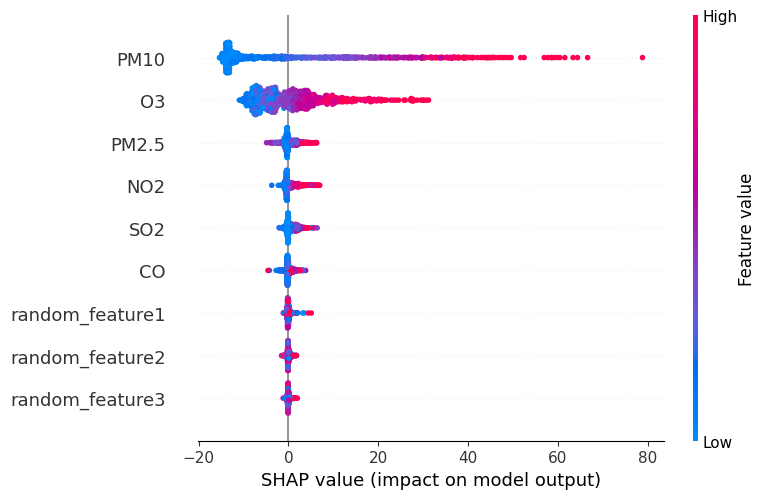

In [17]:
shap.summary_plot(shap_values, X_test)

In [18]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Создаём таблицу с признаками
shap_df = pd.DataFrame({
    "Feature": X_test.columns,        # названия признаков
    "MeanAbsSHAP": mean_abs_shap       # среднее абсолютное SHAP
})

# Сортируем по важности
shap_df = shap_df.sort_values(by="MeanAbsSHAP", ascending=False)
shap_df

,Feature,MeanAbsSHAP
5,PM10,14.4076
3,O3,5.9405
4,PM2.5,0.9571
1,NO2,0.8836
2,SO2,0.8374
0,CO,0.5064
6,random_feature1,0.2312
7,random_feature2,0.2204
8,random_feature3,0.1824


По SHAP анализу из графика и числовых значений важности, самые нерелеватные признаки:
- random_feature1
- random_feature2
- random_feature3

### Permutation Importance

In [19]:
perm_importance = permutation_importance(
    model, X_test, y_test, n_repeats=10
)

importances = pd.Series(
    perm_importance.importances_mean,
    index=X.columns
).sort_values(ascending=False)

importances

PM10               1.1735
O3                 0.3195
SO2                0.0288
PM2.5              0.0275
NO2                0.0209
CO                 0.0124
random_feature1    0.0004
random_feature3   -0.0001
random_feature2   -0.0009
dtype: float64

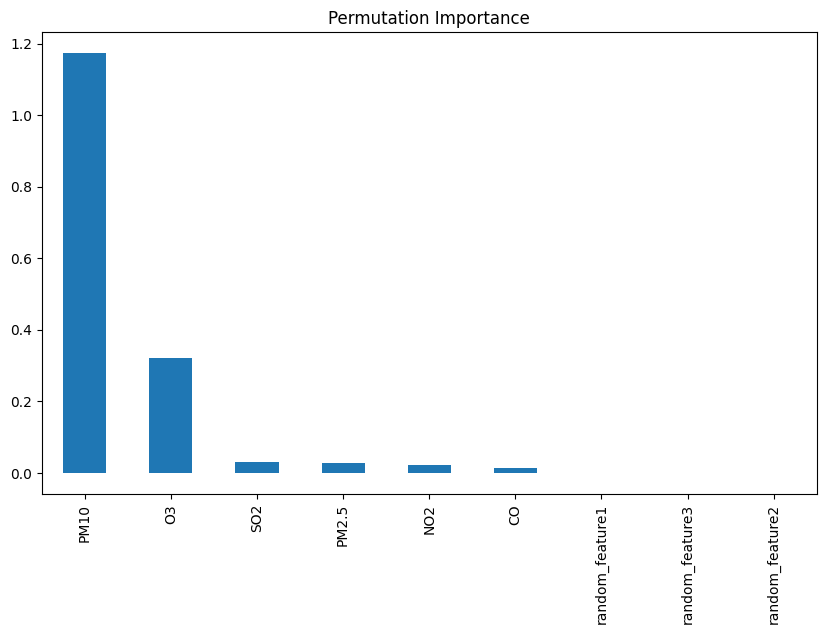

In [20]:
plt.figure(figsize=(10, 6))
importances.plot(kind="bar")
plt.title("Permutation Importance")
plt.show()

По анализу Permutation Importance - случайные признаки также неважны для целевой переменной.

## Исключение наименее значимых признаков


Тут уже исходя из проведенных анализов попросят выкинуть неважные признаки, берем несколько неважных (например, случайных), и выбрасываем из основго датасета.

Важно, аргументировать почему мы это делаем. Также нужно аргументировать, почему некоторые неважные колонки все-таки нужно оставить: айди, метки и тд.

In [22]:
df_total = df.drop(['random_feature1', 'random_feature2', 'random_feature3'], axis=1)
df_total.head()

,CO,NO2,SO2,O3,PM2.5,PM10,AQI
0,325.0000,21.1000,2.5000,35.0000,15.4000,15.6000,20.4833
1,369.0000,20.8000,2.7000,35.0000,15.1000,15.3000,20.4250
2,419.0000,20.4000,3.0000,34.0000,15.6000,15.8000,20.3333
3,451.0000,20.5000,3.1000,33.0000,16.4000,16.6000,20.2583
4,458.0000,22.1000,3.0000,29.0000,17.7000,17.8000,20.3167
